# Building autoregressive models

## Introduction
In the following, we will construct a *first-order auto-regressive model*
with Gaussian errors.
Mathematically, this is expressed by

$$
x_0 \sim \mathcal{N}(\mu_0, \Lambda_0), \\
x_{t+1} = \phi x_t + \varepsilon_t, \quad \varepsilon \sim \mathcal{N}(0, \Lambda).
$$

The latter equation is equivalent to the likelihood
$$
x_{t+1} \mid x_t \sim \mathcal{N}(\phi x_t, \Lambda).
$$

Under this model, the joint distribution over $x_1, \dots, x_N$ (where $N$ is
the number of steps) is Gaussian:
$$
\begin{pmatrix} x_0 \\ x_1 \\ x_2 \\ \vdots \\ x_{N-1} \\ x_N \end{pmatrix}
\sim \mathcal{N}\left(
\begin{pmatrix} \mu_0 \\ \phi \mu_0 \\ \phi^2 \mu_0 \\ \vdots \\
\phi^{N-1} \mu_0 \\ \phi^N \mu_0 \end{pmatrix},
\begin{pmatrix} \Lambda_0 & -\phi & & & & & \\
-\phi & \Lambda + \phi^2 & -\phi & & & & \\
& & & & & & \\
& & \ddots & \ddots & \ddots & & \\
& & & & & & \\
& & & & -\phi & \Lambda + \phi^2 & -\phi \\
& & & & & -\phi & \Lambda
\end{pmatrix}^{-1}
\right).
$$
The first-order Markov structure of the model results in a tridiagonal
precision matrix. Thus, if we work with this Gaussian distribution in
precision form (also commonly called *information form*), we gain tremendous
computational benefits. By contrast, the *covariance matrix* of this Gaussian
is fully dense.

More generally, this package deals with *any* sparse
precision matrix, not just tridiagonal ones. Such Gaussians with sparse
precision matrices are called *GMRFs* (short for
Gaussian Markov Random Fields).

In the following, we construct a GMRF for the above first-order autoregressive
model first manually by computing the mean and precision, and then
automatically by simply specifying the parameters of the model.

## Building an AR(1) model
We begin by loading `GaussianMarkovRandomFields` and `LinearAlgebra`.

In [1]:
using GaussianMarkovRandomFields, LinearAlgebra

We define a discretization of the real interval $[0, 1]$, and specify
some example parameters for the AR(1) model:

In [2]:
xs = 0:0.01:1
N = length(xs)
ϕ = 0.995
Λ₀ = 1e6
Λ = 1e3

1000.0

Now we compute the mean and the precision matrix of the joint distribution.
We explicitly declare the precision matrix as a symmetric tridiagonal matrix,
which unlocks highly efficient linear algebra routines for the underlying
computations.

In [3]:
μ = [ϕ^(i - 1) for i in eachindex(xs)]
diag = [[Λ₀]; repeat([Λ + ϕ^2], N - 2); [Λ]]
off_diag = repeat([-ϕ], N - 1)
Q = SymTridiagonal(diag, off_diag)
x = GMRF(μ, Q)

GMRF{Float64}(
mean: [1.0, 0.995, 0.990025, 0.985074875, 0.980149500625, 0.975248753121875, 0.9703725093562656, 0.9655206468094842, 0.9606930435754368, 0.9558895783575596  …  0.6337242817644086, 0.6305556603555866, 0.6274028820538087, 0.6242658676435396, 0.6211445383053219, 0.6180388156137954, 0.6149486215357264, 0.6118738784280477, 0.6088145090359075, 0.6057704364907279]
precision: 101×101 LinearMaps.WrappedMap{Float64} of
  101×101 LinearAlgebra.SymTridiagonal{Float64, Vector{Float64}}
solver_ref: Base.RefValue{AbstractSolver}(CholeskySolver{TakahashiStrategy}([1.0, 0.995, 0.990025, 0.985074875, 0.980149500625, 0.975248753121875, 0.9703725093562656, 0.9655206468094842, 0.9606930435754368, 0.9558895783575596  …  0.6337242817644086, 0.6305556603555866, 0.6274028820538087, 0.6242658676435396, 0.6211445383053219, 0.6180388156137954, 0.6149486215357264, 0.6118738784280477, 0.6088145090359075, 0.6057704364907279], 101×101 LinearMaps.WrappedMap{Float64} of
  101×101 LinearAlgebra.SymTridiag

A GMRF is a multivariate Gaussian, and it's compatible with
`Distributions.jl`. We can get its mean, marginal standard deviation, and
draw samples as follows:

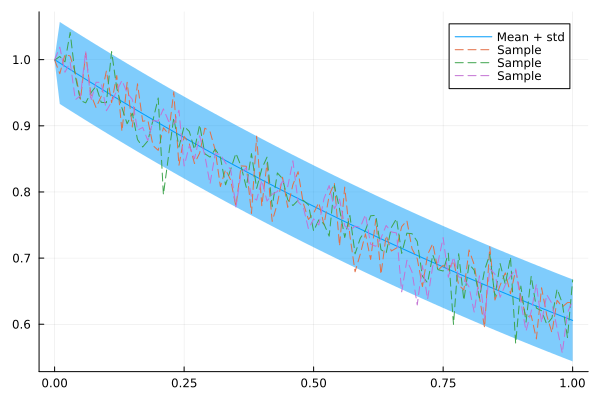

In [4]:
using Plots, Distributions
plot(xs, mean(x), ribbon = 1.96 * std(x), label = "Mean + std")
for i = 1:3
    plot!(xs, rand(x), fillalpha = 0.3, linestyle = :dash, label = "Sample")
end
plot!()

Great! Looks like an AR(1) model.

But what can you do with this? Well, for example you can use it as a prior
for Bayesian inference. If we have a likelihood of the form
$$
y \mid x \sim \mathcal{N}(Ax, \Lambda_{\text{obs}}^{-1}),
$$
then the posterior conditioned on these observations is again a GMRF, the
moments of which we can compute in closed form.
In terms of code, we achieve this through `condition_on_observations`. Let's
condition our model on the observations $x_{26} = 0.85$ and $x_{76} = 0.71$:

In [5]:
using SparseArrays
A = spzeros(2, N)
A[1, 26] = 1.0
A[2, 76] = 1.0
y = [0.85, 0.71]
Λ_obs = 1e6
x_cond = condition_on_observations(x, A, Λ_obs, y)

LinearConditionalGMRF of size 101 and solver LinearConditionalCholeskySolver{RBMCStrategy}

Indeed, our model now conforms to these observations:

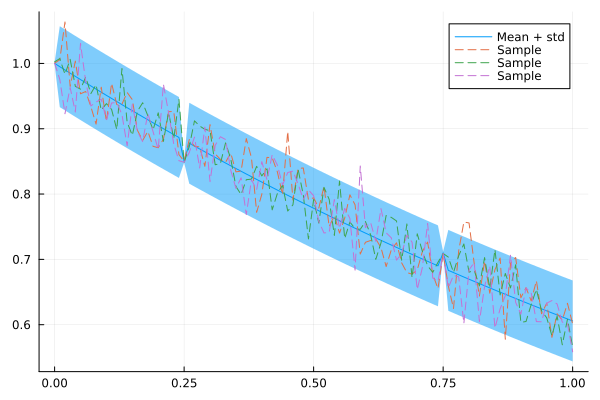

In [6]:
plot(xs, mean(x_cond), ribbon = 1.96 * std(x_cond), label = "Mean + std")
for i = 1:3
    plot!(xs, rand(x_cond), fillalpha = 0.3, linestyle = :dash, label = "Sample")
end
plot!()

## Beyond first-order models: CARs
You may have noticed that the AR(1) model above produces very rough samples.
This may or may not be desirable, depending on the application.
If we do want smoother samples, we can increase the *order* of the model.
This adds off-diagonals to the precision matrix and thus reduces its sparsity,
so computations become a bit more expensive. But it may be worth the overhead.

One model class to produce autoregressive models with flexible conditional
dependencies and sparse precision matrices is that of *conditional
autoregressive models* (*CAR*s). Such models are constructed based on a graph
representation of the underlying data, where there is an edge between two
nodes if they are conditionally dependent.

Let us construct an adjacency matrix that relates nodes not only to their
immediate neighbors, but also to the neighbors' neighbors (a second-order
model).

In [7]:
W = spzeros(N, N)
for i = 1:N
    for k in [-2, -1, 1, 2]
        j = i + k
        if 1 <= j <= N
            W[i, j] = 1.0 / abs(k)
        end
    end
end

Now that we have the adjacency matrix, we can use a GaussianMarkovRandomFields.jl utility function
to generate a CAR model from it, which internally constructs a slight variation
of the graph Laplacian to form the precision matrix.

In [8]:
x_car = generate_car_model(W, 0.9; μ = μ, σ = 0.001)

GMRF{Float64}(
mean: [1.0, 0.995, 0.990025, 0.985074875, 0.980149500625, 0.975248753121875, 0.9703725093562656, 0.9655206468094842, 0.9606930435754368, 0.9558895783575596  …  0.6337242817644086, 0.6305556603555866, 0.6274028820538087, 0.6242658676435396, 0.6211445383053219, 0.6180388156137954, 0.6149486215357264, 0.6118738784280477, 0.6088145090359075, 0.6057704364907279]
precision: 101×101 LinearMaps.WrappedMap{Float64} of
  101×101 SparseArrays.SparseMatrixCSC{Float64, Int64} with 499 stored entries
solver_ref: Base.RefValue{AbstractSolver}(CholeskySolver{TakahashiStrategy}([1.0, 0.995, 0.990025, 0.985074875, 0.980149500625, 0.975248753121875, 0.9703725093562656, 0.9655206468094842, 0.9606930435754368, 0.9558895783575596  …  0.6337242817644086, 0.6305556603555866, 0.6274028820538087, 0.6242658676435396, 0.6211445383053219, 0.6180388156137954, 0.6149486215357264, 0.6118738784280477, 0.6088145090359075, 0.6057704364907279], 101×101 LinearMaps.WrappedMap{Float64} of
  101×101 SparseArra

Let's take our CAR for a test drive:

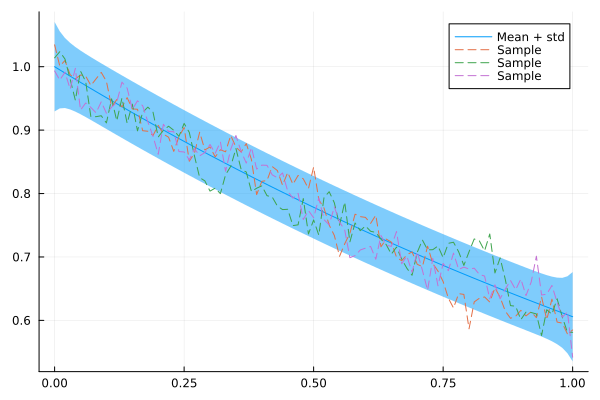

In [9]:
plot(xs, mean(x_car), ribbon = 1.96 * std(x_car), label = "Mean + std")
for i = 1:3
    plot!(xs, rand(x_car), fillalpha = 0.3, linestyle = :dash, label = "Sample")
end
plot!()

Let's see how this model fits data. We take the same observations as for the
AR(1) model, but also add an observation for the starting point to reduce
the uncertainty there.

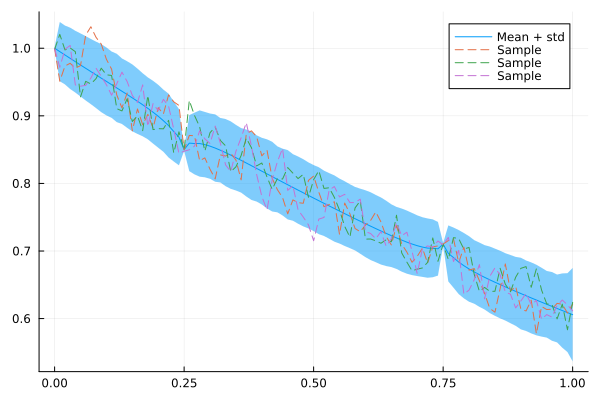

In [10]:
A = spzeros(3, N)
A[1, 1] = 1.0
A[2, 26] = 1.0
A[3, 76] = 1.0
y = [1.0, 0.85, 0.71]
Λ_obs = 1e6
x_car_cond = condition_on_observations(x_car, A, Λ_obs, y)
plot(xs, mean(x_car_cond), ribbon = 1.96 * std(x_car_cond), label = "Mean + std")
for i = 1:3
    plot!(xs, rand(x_car_cond), fillalpha = 0.3, linestyle = :dash, label = "Sample")
end
plot!()

As expected, the interpolation of this model is less abrupt and spiky than
for the AR(1) model.

## Outlook
CAR models are quite flexible. Particularly for spatial data however, it is
more common to model continuously through a Gaussian process. Fortunately, it
turns out that popular Gaussian processes can be approximated quite nicely
through GMRFs, allowing us to do the modelling in terms of a GP and the
computations in terms of a GMRF. To learn more about this approach, check the
tutorial on Spatial Modelling with SPDEs.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*